# Ex 2.3
## Model Formulation

\begin{align*}
\min~& \sum_{k=1}^{K} \sum_{e \in \mathcal{A}} c^k_e x^k_e \\
&\sum_{e\in \mathcal{A} ~:~ t(e)=v} x^k_e - \sum_{e\in \mathcal{A} ~:~ h(e)=v} x^k_e 
= b^k_v,~ \mbox{ for } v \in \mathcal{N},~ k=1,2,\ldots,K;\\
& \sum_{k=0}^{K}  x^k_{e} \leq u_e,~ \forall e \in \mathcal{A};\\
&  x^k_{e}\geq 0,~ \forall e \in \mathcal{A}; \\
& k=1.\\
\end{align*} 


In [2]:
%reset -f
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [3]:
# parameters
solveLPOnly=True      # set False to solve as an IP

## Input Data
- $s$ represents the supply node; and $d$ represents the demand node
- $End$ is set to absorb the left-over blood when supply is larger than demand

In [4]:
# # Some toy data: 1 commodity
Supplies= {
# # node i: [supply commodity[1] ... supply commodity[K]],
     'Os': [10.],
     'Od': [-3.],
     'As': [9.],
     'Ad': [-4.],
     'Bs': [5.],
     'Bd': [-6.],
     'ABs': [4.],
     'ABd': [-10.],
     'End': [-5.] # the blood bank to keep left-over blood
     }

CapacityCosts = {
# # arc (i,j): [capacity, cost commodity[1] ... cost commodity[K]],
     ('Os','Od'): [8., -1],
     ('Os','Ad'): [8., 3],
     ('As','Ad'): [6., -1],
     ('Os','Bd'): [8., 3],
     ('Bs','Bd'): [3., -1],
     ('Os','ABd'): [8., 7],
     ('As','ABd'): [5., 2],
     ('Bs','ABd'): [4., 2],
     ('ABs','ABd'): [5., -1],
     ('Od','End'): [8., -1],
     ('Ad','End'): [5., 3],
     ('Bd','End'): [5., 3],
     ('ABd','End'): [5., 7]
}

In [5]:
Nodes=list(Supplies.keys()) # get node list from supply data
K=len(Supplies[Nodes[0]]) # get number of commodities from supply data
Commods=list(range(1,K+1)) # name the commodities 1,2,...,K
Arcs=list(CapacityCosts.keys()) # get arc list from Capacity/Cost data
ArcsCrossCommods=list(itertools.product(Arcs,Commods)) # make cross product of Arcs and Commods for variable indexing

In [6]:
ArcsCrossCommods

[(('Os', 'Od'), 1),
 (('Os', 'Ad'), 1),
 (('As', 'Ad'), 1),
 (('Os', 'Bd'), 1),
 (('Bs', 'Bd'), 1),
 (('Os', 'ABd'), 1),
 (('As', 'ABd'), 1),
 (('Bs', 'ABd'), 1),
 (('ABs', 'ABd'), 1),
 (('Od', 'End'), 1),
 (('Ad', 'End'), 1),
 (('Bd', 'End'), 1),
 (('ABd', 'End'), 1)]

In [7]:
model = gp.Model()
if solveLPOnly==True:
    x = model.addVars(ArcsCrossCommods)   # Model.addVars() : Add multiple decision variables to a model.             
else:
    x = model.addVars(ArcsCrossCommods,vtype=GRB.INTEGER)        
model.setObjective(sum(sum(CapacityCosts[i,j][k]*x[(i,j),k] for (i,j) in Arcs) for k in Commods), GRB.MINIMIZE)
model.addConstrs(sum(x[(i,j),k] for k in Commods) <= CapacityCosts[i,j][0] for (i,j) in Arcs)
model.addConstrs(
  (sum(x[(i, j),k] for j in Nodes if (i, j) in Arcs) - sum(x[(j, i),k] for j in Nodes if (j,i) in Arcs)   
   == Supplies[i][k-1] for i in Nodes for k in Commods))
model.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


In [8]:
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Flows:")
for (i,j) in Arcs: 
    arcflow=""
    for k in Commods:
        arcflow += str(round(x[(i,j),k].X,4))
        arcflow += "  "
    print("x[(",i,",",j,"), *]=", arcflow, "capacity:", CapacityCosts[i,j][0])

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 13 columns and 39 nonzeros
Model fingerprint: 0xc704cd5b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve removed 20 rows and 8 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+00
 
***** Flows:
x[( Os , Od ), *]= 7.0   capacity: 8.0
x[( Os , Ad ), *]= 0.0   capacity: 8.0
x[( As , Ad ), *]= 5.0   capacity: 6.0
x[( Os , Bd ), *]= 3.0   capacity: 8.0
x[( Bs , Bd ), *]= 3.0   cap

Network with node labels and capacities/costs on arcs


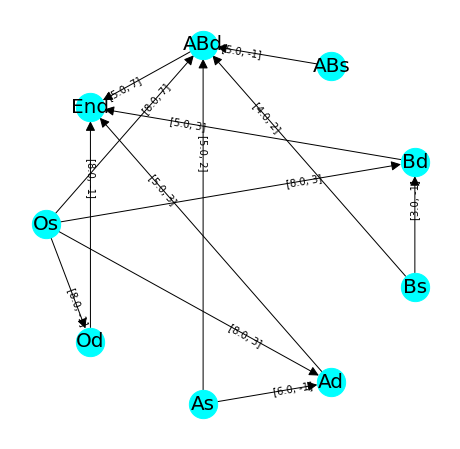

In [9]:
G = nx.DiGraph()
G.add_nodes_from(Nodes)
G.add_edges_from(Arcs)
plt.figure(figsize=(8,8))
edge_labels=nx.draw_networkx_edge_labels(G,edge_labels=CapacityCosts,
    pos=nx.shell_layout(G), label_pos=0.3, font_size=10)
nx.draw_shell(G, with_labels=True, node_color='cyan', node_size=800, 
    font_size=20, arrowsize=20)
print("Network with node labels and capacities/costs on arcs")

Network with supplies and flows for commodity  1


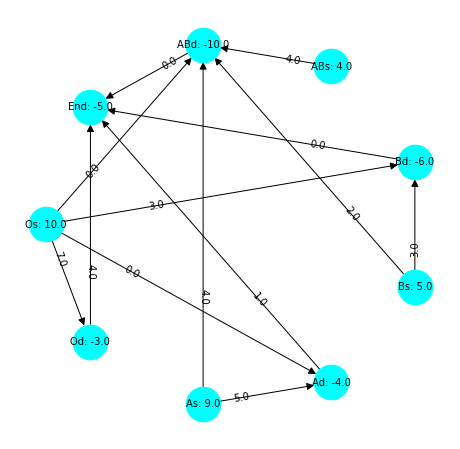

In [10]:
for k in Commods:
    Supply1_label={}
    for i in Nodes:
        Supply1_label[i]= str(i)+': '+str(Supplies[i][k-1])

    Flow0=np.zeros(len(Arcs))
    Flow=dict(zip(list(Arcs), Flow0))
    for (i,j) in Arcs: Flow[i,j]= str(round(x[(i,j),k].X,4)) 
    H=nx.relabel_nodes(G, Supply1_label)
    plt.figure(figsize=(8,8))
    edge_labels=nx.draw_networkx_edge_labels(H,edge_labels=Flow,
        pos=nx.shell_layout(G), label_pos=0.7, font_size=10)
    nx.draw_shell(H, with_labels=True, node_color='cyan', 
         node_size=1200, font_size=10, arrowsize=15)
    print("Network with supplies and flows for commodity ",k)